In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import cv2
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import xml.etree.ElementTree as ET
import os
import sys

from six.moves import xrange as range
try:
    from tensorflow.python.ops import ctc_ops
except ImportError:
    from tensorflow.contrib.ctc import ctc_ops

import random
import scipy
import glob
import json
import scipy.io
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple, MultiRNNCell
import tensorflow.contrib.slim as slim
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import variable_scope
from IPython.display import clear_output
from tensorflow.python.ops import rnn
from tensorflow.python.ops import math_ops
from IPython import display

In [3]:
tf.__version__

'1.4.1'

In [4]:
def _shape(tensor):
  """Get the shape of a tensor as an int list."""
  return tf.unstack(tf.shape(tensor))
def get_blocks(images,  width, height,bb, kernel_size=[1,1]):
  """Split images in blocks

  Args:
    images: (num_images, height, width, depth) tensor
    kernel_size: A list of length 2 holding the [kernel_height, kernel_width] of
      of the pooling. Can be an int if both values are the same.

  Returns:
    (num_images, height/kernel_height, width/kernel_width,
    depth*kernel_height*kernel_width) tensor
  """
  with variable_scope.variable_scope("image_blocks"):
    batch_size, _, _, chanels = _shape(images)
    h, w = height//kernel_size[0], width//kernel_size[1]
    features = kernel_size[1]*kernel_size[0]*images.get_shape().as_list()[3]    

    lines = array_ops.split(images, h, axis=1)
    line_blocks = []
    for line in lines:
      line = array_ops.transpose(line, [0, 2, 3, 1])
      line = array_ops.reshape(line, [batch_size, w, features])
      line_blocks.append(line)
    
    return array_ops.stack(line_blocks, axis=1)

In [5]:
def ndlstm_base_dynamic(inputs, noutput, sequence_length, scope=None, reverse=False):
  
  with variable_scope.variable_scope(scope, "SeqLstm", [inputs]):
    # TODO(tmb) make batch size, sequence_length dynamic
    # example: sequence_length = tf.shape(inputs)[0]
    _, batch_size, _ = tf.unstack(tf.shape(inputs))#_shape(inputs)
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(noutput, state_is_tuple=True)
    state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    #state = array_ops.zeros([batch_size, lstm_cell.state_size])
    #sequence_length = int(inputs.get_shape()[0])
    sequence_lengths = math_ops.to_int64(
        array_ops.fill([batch_size], sequence_length))
    if reverse:
      inputs = array_ops.reverse_v2(inputs, [0])
    outputs, _ = rnn.dynamic_rnn(
        lstm_cell, inputs, sequence_lengths, state, time_major=True)
    #print(outputs)
    if reverse:
      outputs = array_ops.reverse_v2(outputs, [0])
    return outputs


def horizontal_lstm(images, num_filters_out, lengs, h, bb, scope=None):
  
  with variable_scope.variable_scope(scope, "HorizontalLstm", [images]):
    batch_size, _, _, _ = tf.unstack(tf.shape(images))
    #sequence = images_to_sequence(images)
    num_image_batches, height, width, depth =  tf.unstack(tf.shape(images))
    transposed = array_ops.transpose(images, [2, 0, 1, 3])
    sequence = array_ops.reshape(transposed,
                           [lengs, num_image_batches * h, images.get_shape().as_list()[3]])
    
    with variable_scope.variable_scope("lr"):
      hidden_sequence_lr = ndlstm_base_dynamic(sequence, num_filters_out // 2, lengs)
    with variable_scope.variable_scope("rl"):
      hidden_sequence_rl = (ndlstm_base_dynamic(
          sequence, num_filters_out - num_filters_out // 2, lengs, reverse=1))
    output_sequence = array_ops.concat([hidden_sequence_lr, hidden_sequence_rl],
                                       2)
    #output = sequence_to_images(output_sequence, batch_size)
    width, num_batches, depth = _shape(output_sequence)
    height = num_batches // batch_size
    reshaped = array_ops.reshape(output_sequence,
                               [lengs, batch_size, h, output_sequence.get_shape().as_list()[2]])
    return array_ops.transpose(reshaped, [1, 2, 0, 3])
    

def separable_lstm(images, num_filters_out, lengs, h, bb,  kernel_size=None, scope=None , nhidden=None):
  
  with variable_scope.variable_scope(scope, "SeparableLstm", [images]):
    if nhidden is None:
      nhidden = num_filters_out
    if kernel_size is not None:
      #images = get_blocks(images, kernel_size)
      images = get_blocks(images,lengs,h, bb, kernel_size)
      print(images)
      lengs = lengs//kernel_size[1]
      h = h//kernel_size[0]
    hidden = horizontal_lstm(images, nhidden,lengs, h, bb)
    with variable_scope.variable_scope("vertical"):
      transposed = array_ops.transpose(hidden, [0, 2, 1, 3])
      output_transposed = horizontal_lstm(transposed, num_filters_out,h, lengs, bb)
    output = array_ops.transpose(output_transposed, [0, 2, 1, 3])
    return output
print('no errors')

no errors


In [6]:

def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq[0]), range(len(seq[0]))))
        values.extend(seq[0])

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape



In [7]:
def voc():
    vocabulary = {}
    vocabulary_path = "some.mat"
    

    if False and os.path.exists(vocabulary_path):
        imgs=scipy.io.loadmat(vocabulary_path)['vocabulary']
    else:
        nrC=1
        vocabulary['%%'] = 0 

        c = '0'

        while ord(c) != ord('9')+1:
            vocabulary[c] = nrC
            nrC = nrC + 1
            c = chr(ord(c)+1)
        c = 'A'
        while ord(c) != ord('Z')+1:
            vocabulary[c] = nrC
            nrC = nrC + 1
            c = chr(ord(c)+1)

        c = 'a'
        while ord(c) != ord('z')+1:
            vocabulary[c] = nrC
            nrC = nrC + 1
            c = chr(ord(c)+1)

        cr = [',','.','"','\'','-','#','(',')',';','?',':','*','&','!','/','+']
        for c in cr:
            vocabulary[c] = nrC
            nrC = nrC + 1

        vocabulary[' '] = nrC
        nrC += 1
        vocabulary['~'] = nrC
    return vocabulary

In [8]:
devkit_path = '/data/sparks/user/imosnoi/datasets/hw/'

vocab = voc()
Ivocab = {i:j for (j,i) in vocab.items()}
maxs = {'text':0,'textMin':100,'top':0,'bottom':10000,'bb':0}

def addRect(d,p,k):
    h1,w1=0.282326369283*0.25, 0.282371924163*0.25
    x1, y1, x2, y2 = p
    for i in range(int(x1*w1),int(x2*w1)):
        for j in range(int(y1*h1),int(y2*h1)):
            d[j,i,k] = 1.0
    #return d
    
def addLi(d,p,k):
    h1,w1=0.282326369283*0.25, 0.282371924163*0.25
    x1, y1, x2, y2 = p
    #for i in range(int(x1*w1),int(x2*w1)):
    for j in range(int(y1*h1),int(y2*h1)):
            d[j,k] = 1.0
    
def BB(b=0,e=2):
    gt_roidb = []
    for  nameIMG  in sorted(glob.glob(devkit_path+"form/*.png"))[b:e]:
        name = nameIMG.split('/')[-1].split('.')[0]
        nameXml = devkit_path + "xml/" + name + '.xml'
        tree = ET.parse(nameXml)
        root = tree.getroot()
        boxes = []# np.zeros((num_objs, 4), dtype=np.uint16)
        text = []
        img  = cv2.imread(nameIMG)

        #print(1000/img.shape[0],700/img.shape[1])
        #img = cv2.resize(img, (0,0), fx=0.3, fy=0.3) 
        img = cv2.resize(img, (700,1000)) 
        #print(img.shape)
        #img = 

        # Load object bounding boxes into a data frame.
        ix = 0
        maxH = 1000000
        d = np.zeros((1000//4,13))
        for i,line in enumerate(root[1]):
                if False and line.attrib['segmentation']!='ok' or int(line.attrib['dsy'])-int(line.attrib['asy'])>maxH:
                    continue    
                x1, y1, x2, y2 = 10000, 10000, 0, 0
                t = ''
                for word in line:      
                        if(word.tag == "lower-contour" or word.tag == "upper-contour" or len(word) == 0 ):
                                #xb, yb, xe, ye = form.shape[1], form.shape[0], 0, 0
                                t = ''
                                continue 
                        #print (word.attrib.keys())
                        #return 1
                        for letter in word:                        
                            x1 = min(x1, int(letter.attrib['x'])) - 1
                            y1 = min(y1, int(letter.attrib['y'])) - 1
                            x2 = max(x2, int(letter.attrib['x']) + int(letter.attrib['width'])) - 1
                            y2 = max(y2, int(letter.attrib['y']) + int(letter.attrib['height'])) - 1
                #print(xb,yb,xe,ye)

                #line level boxes
                if x1 == 10000 or y1 == 10000:
                    continue
                cls = 1 if x2-x1>1000 else 2
                boxes.append([x1, y1, x2, y2])
                addLi(d,[x1, y1, x2, y2],len(boxes)-1)
                text.append([[vocab[k] for k in  line.attrib['text']+"~"]])

                maxs['text'] = max(len(line.attrib['text']),maxs['text'])
                maxs['textMin'] = min(len(line.attrib['text']),maxs['textMin'])
                maxs['top'] = max(y2,maxs['top'])
                maxs['bb'] = max(len(boxes),maxs['bb'])
                maxs['bottom'] = min(y1,maxs['bottom'])
        while len(text) < 13:
            text.append([[vocab['~']]])
        #print(len(text))
        gt_roidb.append([img,boxes,text,d])
        
    return gt_roidb
gt_roidb = BB(b=1200,e=1204)
print('no err:',len(gt_roidb),maxs,len(sorted(glob.glob(devkit_path+"form/*.png"))))

no err: 4 {'text': 60, 'top': 2453, 'textMin': 9, 'bb': 10, 'bottom': 510} 1539


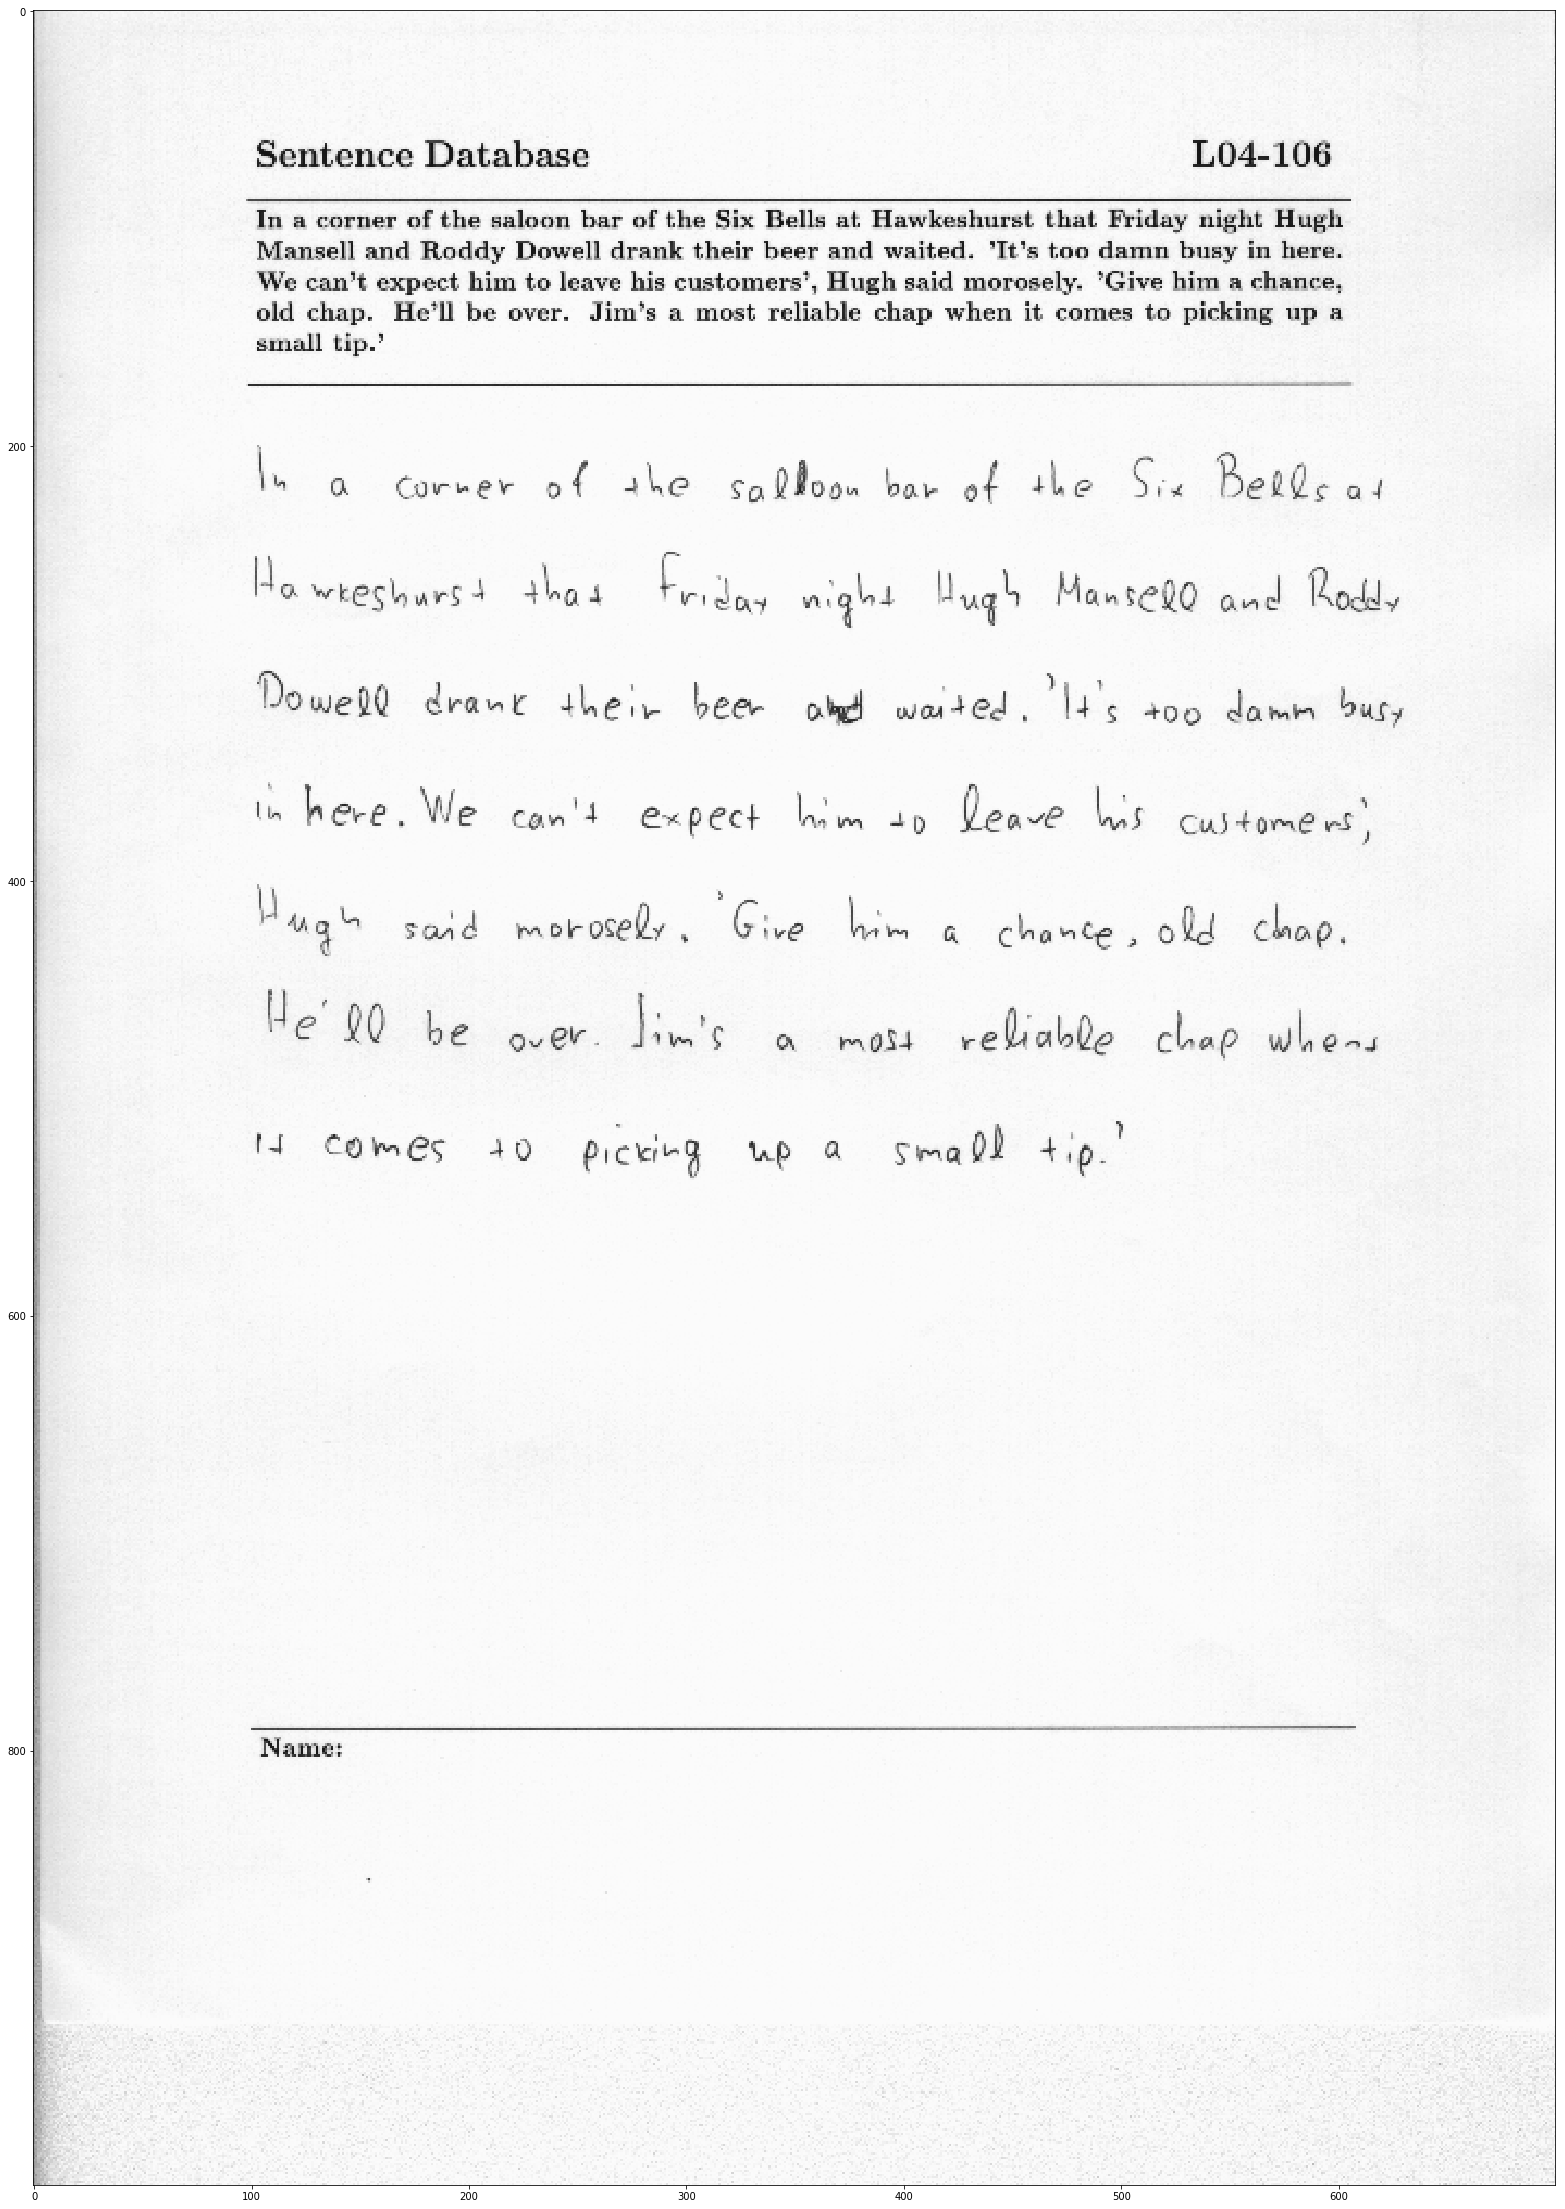

In [9]:
plt.figure(figsize=(40,40))
plt.imshow(gt_roidb[0][0])

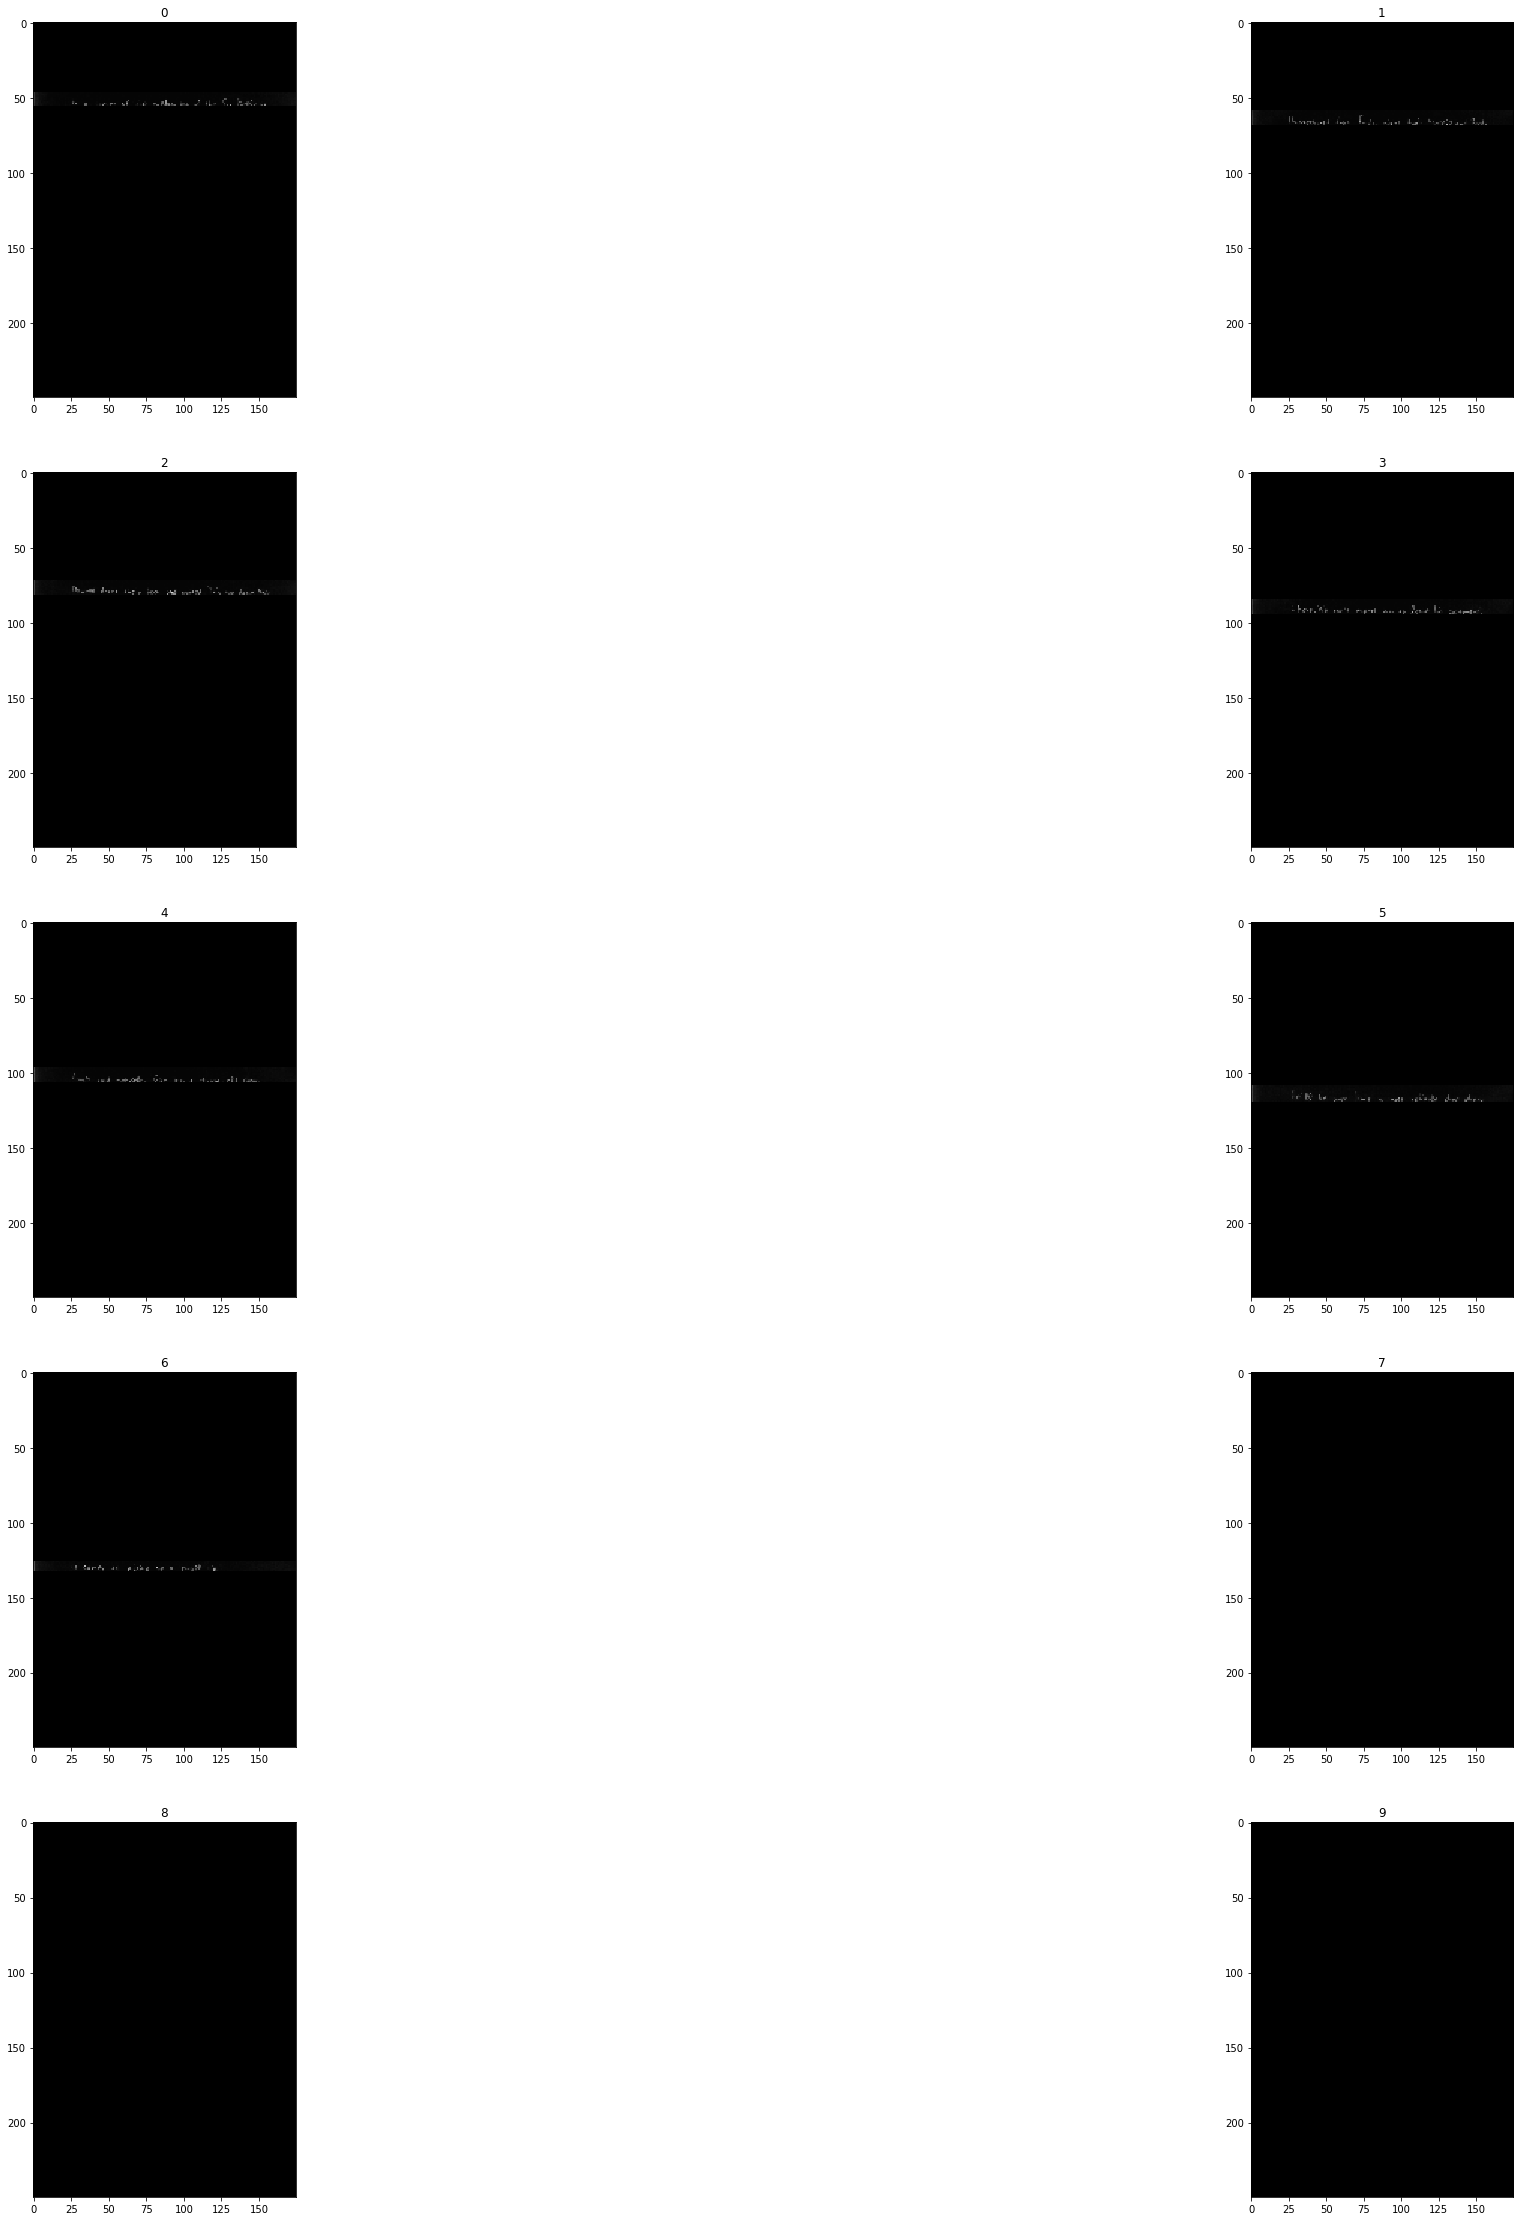

In [10]:
plt.figure(figsize=(40,40))
img = gt_roidb[0][0]
img = cv2.resize(img, (175,250)) 
d = gt_roidb[0][3]
#print(d.shape,img.shape)
#plt.imshow(img)
for i in range(10):
    plt.subplot(5,2,1+i)
    plt.title(i)
    plt.imshow(np.tile(np.expand_dims(np.expand_dims(d[:,i],-1),-1),(1,175,3))*img)

In [18]:
height = 128
vocab_size = 82#len(vocab_info)
beam_size = 10
graph = tf.Graph()
with graph.as_default(): 
    images = tf.placeholder(tf.float32, [None, None, None, 3],name='images')
    att = tf.placeholder(tf.float32, [None, 13],name='att')
    lens = tf.placeholder(tf.int32, [],name='lens')
    bb = tf.placeholder(tf.int32, [],name='bacth')
    hei = tf.placeholder(tf.int32, [],name='hey')
    targets = tf.sparse_placeholder(tf.int32,name='targets')
    is_training = tf.placeholder_with_default(True,[],name='is_training')
    
    tf.add_to_collection("images", images)
    tf.add_to_collection("lens", lens)
    #tf.add_to_collection("targets", targets)
    tf.add_to_collection("is_training", is_training)
    
    batch_norm_params = {'is_training': is_training, 'decay': 0.9, 'updates_collections': None}
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=batch_norm_params):      
                net = slim.conv2d(images, 32, [5, 5], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')
                #print(net)
                #net  = separable_lstm(net, 64,lens//2, hei//2, bb, None,'l1')    
                net = slim.conv2d(net, 128, [4, 4], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')
                net  = separable_lstm(net, 128,lens//4, hei//4, bb, None,'l2')     
                net = slim.conv2d(net, 156, [3, 3], scope='conv3')           
                
                #transposed = array_ops.transpose(hidden, [0, 2, 1, 3])
                mask =  tf.nn.sigmoid( horizontal_lstm(net, 13, lens//4, hei//4, bb))#b w 13
                mask_ = tf.squeeze(mask,0,name="maskit")#  h w  13
                mask_ = tf.reduce_mean(mask_,axis=1)#,0.01,1)# h 13 
                masks = tf.unstack(mask_,axis=-1)#  13 x h
                n = []
                
                def fr(ne,ma):#b h w 156, w
                    re = tf.transpose(ne,[0,2,3,1])#b w 156 h
                    r1 = re*ma
                    t2 = tf.transpose(r1,[0,3,1,2])#b h w 156
                    return tf.squeeze(t2,0,name="soit")#h w 156 
                #attention
                for m in range(13):
                     n.append(fr(net,masks[m]))
                nets = tf.stack(n)
                
                
                batch_size, h,w,c = tf.unstack(tf.shape(nets))
                net =  tf.transpose(nets, [2,0,1,3])
                net = tf.reduce_mean(net,axis=2)
                #print(net)
                net =  tf.reshape(net, [-1, net.get_shape().as_list()[2]])
                net = slim.fully_connected(net, 300, activation_fn=tf.nn.relu, normalizer_fn=None, scope='fc1')
                net = slim.dropout(net, is_training=is_training, scope='dropout1')
                net = slim.fully_connected(net, vocab_size, activation_fn=None, normalizer_fn=None, scope='fc2')
                logits = tf.reshape(net, [ -1, 13, vocab_size])
                
    mask_l =  tf.nn.l2_loss(mask_*(1.0 - att)) - tf.nn.l2_loss(mask_*att)
    
    seq_len = tf.ones([13],dtype=tf.int32)*lens//8
    cost_m = tf.reduce_mean(mask_l)
    
    loss = ctc_ops.ctc_loss(targets, logits,  seq_len)
    cost_l = tf.reduce_mean(loss)
    cost =  cost_m + cost_l 
    
    

    initial_learning_rate = 0.001
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        #optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(initial_learning_rate,  0.9).minimize(cost)

    # Option 2: tf.contrib.ctc.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    #decoded, log_prob = ctc_ops.ctc_greedy_decoder(logits, seq_len)
    decoded, log_prob = ctc_ops.ctc_beam_search_decoder(logits, seq_len,top_paths=beam_size)
    
    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))
    
    #tf.add_to_collection("ler", ler)
    #tf.add_to_collection("cost", cost)
    
    #print(len(decoded))
    for i in range(0):
        tf.add_to_collection("decodedPrediction{}".format(i),tf.sparse_tensor_to_dense(decoded[i]))
    #tf.add_to_collection('logits_softmax',tf.nn.softmax(logits))
    
    tf.summary.scalar('ler', ler) 
    tf.summary.scalar('cost_m', cost_m) 
    tf.summary.scalar('cost_l', cost_l) 
    #for variable in slim.get_model_variables():
    #  tf.summary.histogram(variable.op.name, variable)
    
    merged_summary_op = tf.summary.merge_all()
    
    print('no erors')

no erors


In [8]:
#!mkdir -p /data/sparks/user/imosnoi/logs/hw/atCtcMdlstm

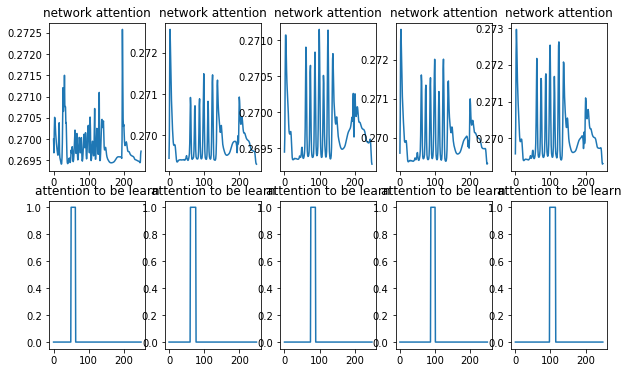

e
That's rather the point, isn't it?&quot; &quot;No, but I mean -&quot;~
it: 40 , loss tr: 217.65 , lre tr: 1.54 , loss te: 137.4 , cost_m te: 110.63 , lre te: 0.98 , t: 13.22 (175, 13, 82)
interrupted! 50


In [ ]:
'''
'''

batch = 1
ws = 10
nrs = 0
restore = None#'/data/sparks/user/imosnoi/logs/hw/atCtcMdlstm/models/mdlstm-pool/mblstm-width-free-5.ckpt'
save = '/data/sparks/user/imosnoi/logs/hw/atCtcMdlstm/models/mdlstm-pool/mblstm-width-free-v2.ckpt'
logdir = '/data/sparks/user/imosnoi/logs/hw/atCtcMdlstm/models/mdlstm-pool/'
print('st->>')

with tf.Session(graph=graph) as session:
    try:
        #summary_writerTest = tf.summary.FileWriter(os.path.join(logdir, 'test'), session.graph) 
        #summary_writerTrain = tf.summary.FileWriter(os.path.join(logdir, 'train'), session.graph) 
        saver = tf.train.Saver(tf.global_variables())
        tf.global_variables_initializer().run()
        if restore:
            saver.restore(session, restore)
            print("Model restored.",restore)
        #global_step = tf.get_collection("global_step")[0]
        start = time.time()
        bt = 0
        lr = 0
        nr = 0
        it = 4
        
        
        #gt_roidbT = BB(b=1500,e=1502)
        #print(len(gt_roidbT))
        for j in range(1000):
            
            #print(lengts)
            ins = np.random.randint(0,1300)
            gt_roidb = BB(b=ins,e=ins+10)
                
                #print('changed test data',nrs, len(batches),len(batchesT))
            for i in range(len(gt_roidb)):  
                    #print(i)
                    #print([len(g[0]) for g in gt_roidb[i][2]])
                    feed = {images: np.array([gt_roidb[i][0]]),att:np.array(gt_roidb[i][3]),
                            targets: sparse_tuple_from(gt_roidb[i][2]),
                            lens:gt_roidb[i][0].shape[1],hei:gt_roidb[i][0].shape[0]}
                    
                    #print(session.run(logits, feed).shape)
                    #break
                    if nrs % 10 == 0 and nrs>0:     
                        ins = np.random.randint(1500,1520)
                        gt_roidbT = BB(b=ins,e=ins+2)
                        end = time.time()
                        btt = 0
                        bbm = 0
                        lle = 0
                        for ii in range(len(gt_roidbT)):
                            feed = {images: np.array([gt_roidbT[ii][0]]),
                                    att:np.array(gt_roidbT[ii][3]),
                                    targets: sparse_tuple_from(gt_roidbT[ii][2]),
                                    lens:gt_roidbT[ii][0].shape[1],hei:gt_roidbT[ii][0].shape[0]}
                            if ii == 0:#decoded                                
                                batch_cost,cm,ll,dd,tt,ma,lo = session.run([cost_l,cost_m, ler, 
                                                                tf.sparse_tensor_to_dense(decoded[0]),
                                                                tf.sparse_tensor_to_dense(targets),
                                                                         mask_, logits], feed)
                            else:
                                
                                batch_cost,cm,ll = session.run([cost_l,cost_m, ler], feed)
                            btt += batch_cost
                            bbm += cm
                            #print(ll, batch_cost,'ttes')
                            lle += ll
                        display.clear_output(wait=True)
                        img = gt_roidbT[0][0]
                        d = ma
                        plt.figure(figsize=(10,6))
                        for i in range(5):
                            plt.subplot(2,5,1+i)
                            plt.title('network attention')
                            plt.plot(d[:,i])#np.tile(np.expand_dims(d[:,:,i],-1),(1,1,3))*img)
                        for i in range(5):
                            plt.subplot(2,5,1+5+i)
                            plt.title('attention to be learn')
                            plt.plot(gt_roidbT[ii][3][:,i])
                        plt.pause(0.01)
                        print(''.join([Ivocab[h] for h in dd[0] if h]))
                        print(''.join([Ivocab[h] for h in tt[0]]))
                        print('it:',nrs,', loss tr:',round(bt/nr,2),', lre tr:',round(lr/nr,2),
                              ', loss te:',round(btt/len(gt_roidbT),2),
                              ', cost_m te:',round(bbm/len(gt_roidbT),2),
                              ', lre te:',round(lle/len(gt_roidbT),2),
                              ', t:',round(end-start,2),lo.shape)
                        start = time.time()
                        bt = 0
                        lr = 0
                        nr = 0                        
                    else:
                        batch_cost,ll, _ = session.run([cost, ler, optimizer], feed)
                        #print(ll, batch_cost)
                    bt+=batch_cost
                    lr+=ll
                    nr+=1
                    nrs+=1
                    #print(i)                   
            if save and nrs%1000 ==0 and nrs>0:
                save_path = saver.save(session, save)
                print("model saved:",save_path,nrs)    
        if save:
            save_path = saver.save(session, save)
            print("model saved:",save_path,nrs)
    except KeyboardInterrupt:
                print("interrupted!",nrs)
                if save:
                    save_path = saver.save(session, save)
                    print("model saved:",save_path)

In [ ]:

batch = 5
beam_size = 2

toSave = ''
loaded_Graph = tf.Graph()
with tf.Session(graph=loaded_Graph) as sess:
        save_dir = toSave+'models/mdlstm-pool/mblstm-width-free-2.ckpt'
        loader = tf.train.import_meta_graph(save_dir +'.meta')
        loader.restore(sess, save_dir)   
        # get tensors                
        images_tensor = loaded_Graph.get_tensor_by_name('images:0')
        hei_tensor    = loaded_Graph.get_tensor_by_name('hey:0')
        lens_tensor   = loaded_Graph.get_tensor_by_name('lens:0')
        bb_tensor     = loaded_Graph.get_tensor_by_name('bacth:0')
        #targets_tensor = loaded_Graph.get_tensor_by_name('targets:0')
        is_training_tensor = loaded_Graph.get_tensor_by_name('is_training:0')
        
        decoded_tensor=[]
        for i in range(beam_size):
            decoded_tensor.append(tf.get_collection("decodedPrediction{}".format(i)))
        logits_tensor = tf.get_collection('logits_softmax')[0]
        cost_tensor = tf.get_collection('cost')[0]
        ler_tensor = tf.get_collection('ler')[0]        
        
        batchesT , lengtsT= getData(['batches/words/','batches/sentences/'],0.1,True)
        
        for it in range(0,len(batchesT),batch):
                        start = time.time()
                        feed_t = {images_tensor: np.expand_dims(np.array([ar[0] for ar in \
                                                                   batchesT[it:(it)+batch]]),-1),
                            #targets_tensor: sparse_tuple_from([ar[1] for ar in batchesT[it:(it)+batch]]),
                            lens_tensor:lengtsT[1],hei_tensor:lengtsT[0],is_training_tensor:False}
                        softmax, d = sess.run([logits_tensor, decoded_tensor[0]], feed_t)
                        end=time.time()
                        print('info:',lengtsT,d,softmax.shape,
                              #', loss te:',round(batch_costT,2), ', lre te:',round(llT,2),
                              ', t:',round(end-start,2))
                        break

In [ ]:
plt.imshow(batchesT[0][0])

In [ ]:
len( batches[b])

In [ ]:
(i+1)*batch

In [ ]:
2**8

In [ ]:
#ideas for attention
#boxes = slim.conv2d(mask_, 10*4, [1, 1], scope='boxes')
                '''
                masks =[]# tf.unstack(mask,axis=-1)
                n = []
                nn = []
                def ff(net,n,masks):
                    tt = net* tf.expand_dims(n[-1],0,name="expd")# b h w 156
                    s=separable_lstm(tt,50,lens//4, hei//4, bb, None,'l3') # b h w 10
                    c = slim.conv2d(s, 1, [1, 1], scope='mask')# b h w 1
                    cl = tf.clip_by_value(c,0.01,2.0,name="cl")# b h w 1
                    sc = tf.squeeze(cl,0,name="sc")# h w 1
                    return sc
                #[250,175,1,156] vs. [1,250,175,156]
                with tf.variable_scope("foo"):
                    for m in range(13):
                        if m>0:
                            tf.get_variable_scope().reuse_variables()
                            #slim.conv2d(net, 100, [5, 5], scope='mask_')
                            masks.append(ff(net,nn,masks))
                            nn.append(nn[-1]*(2.0-tf.tile(masks[-1],[1,1,156])))# h w 156
                        else:
                            masks.append(
                                tf.squeeze( # h w 1
                                    tf.clip_by_value( # b h w 1
                                slim.conv2d( # b h w 1
                                    separable_lstm( # b h w 10
                                        net, # # b h w 156
                                                           50,lens//4, hei//4, bb,
                                                           None,'l3'), 1, [1, 1],
                                            scope='mask'),0.01,2.0),0))
                            nn.append(tf.squeeze(net,0)*(2.0-tf.tile(masks[0],[1,1,156])))#  h w 156
                            
                        #m1 = tf.tile(tf.expand_dims(m,-1),[1,1,1,256])
                        #print(m1)
                        #n1 = m1*net
                        n.append(
                            tf.squeeze( # h w 156
                            tf.tile( # b h w 156
                                tf.expand_dims( # b h w 1
                                    masks[m] # h w 1
                                    ,0),
                                [1,1,1,156])*net,
                            0)
                                )
                        #nn.append(n[-1])
                        #h,w,156

                    
                nets = tf.stack(n)
                mask = tf.expand_dims(tf.squeeze(tf.stack(masks,axis=-1),-2),0)
                #nets = slim.max_pool2d(nets, [1, 2], scope='pool3')
                '''